In [49]:
# from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
# from pyspark.ml.clustering import KMeans
# from pyspark.sql import functions as F
# import sys
# from pyspark.sql import SparkSession
# import matplotlib.pyplot as plt
# from pyspark.sql import functions as F
# import seaborn as sns
# from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, BooleanType

In [50]:
# spark = SparkSession.builder \
#     .appName("Data Processing dans catalogue csv") \
#     .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
#     .enableHiveSupport() \
#     .getOrCreate()
# print("Session Spark initialisée avec succès.")
# spark.sql("USE concessionnaire")
# catalogue_df = spark.sql("SELECT * FROM catalogue_co2_merge_processed")

In [51]:
# catalogue_df.show(10)
# catalogue_df.printSchema()


In [55]:
# from pyspark.sql import SparkSession
# from pyspark.sql import functions as F
# from pyspark.sql.functions import when, col, lit
# from pyspark.ml.feature import VectorAssembler, MinMaxScaler
# from pyspark.ml.clustering import KMeans
# 
# # Initialisation de la session Spark
# spark = SparkSession.builder \
#     .appName("Clustering Véhicules") \
#     .enableHiveSupport() \
#     .getOrCreate()
# print("Session Spark initialisée avec succès.")
# spark.sql("USE concessionnaire")
# 
# # Charger les données
# catalogue_df = spark.sql("SELECT * FROM catalogue_co2_merge_processed")
# print(f"Nombre de lignes dans le DataFrame initial : {catalogue_df.count()}")
# catalogue_df.show(5, truncate=False)
# 
# # Étape 0 : Correction des anomalies dans 'rejets_co2'
# 
# # Identifier les anomalies
# anomalies_df = catalogue_df.filter(
#     (col('rejets_co2').isNull()) |
#     (col('rejets_co2') == 0) |
#     ((col('unified_horse_power') > 100) & (col('rejets_co2') < 50))
# )
# print(f"Nombre d'anomalies détectées : {anomalies_df.count()}")
# 
# # Calcul des moyennes
# avg_co2_by_model = F.broadcast(catalogue_df.filter(col('rejets_co2') > 0)
#                                .groupBy('marque', 'modele')
#                                .agg(F.avg('rejets_co2').alias('avg_rejets_co2_model')))
# 
# avg_co2_by_marque = F.broadcast(catalogue_df.filter(col('rejets_co2') > 0)
#                                 .groupBy('marque')
#                                 .agg(F.avg('rejets_co2').alias('avg_rejets_co2_marque')))
# 
# avg_co2_general = catalogue_df.filter(col('rejets_co2') > 0) \
#     .agg(F.avg('rejets_co2').alias('avg_rejets_co2_general')).collect()[0]['avg_rejets_co2_general']
# 
# # Imputation des anomalies
# anomalies_df = anomalies_df \
#     .join(avg_co2_by_model, on=['marque', 'modele'], how='left') \
#     .join(avg_co2_by_marque, on='marque', how='left') \
#     .withColumn('rejets_co2', when(col('avg_rejets_co2_model').isNotNull(), col('avg_rejets_co2_model'))
#                 .when(col('avg_rejets_co2_marque').isNotNull(), col('avg_rejets_co2_marque'))
#                 .otherwise(lit(avg_co2_general))) \
#     .drop('avg_rejets_co2_model', 'avg_rejets_co2_marque')
# 
# # Mise à jour des données
# catalogue_corrected_df = catalogue_df.join(anomalies_df.select('marque', 'modele', 'rejets_co2'), 
#                                            on=['marque', 'modele'], how='left_anti').unionByName(anomalies_df)
# print("Données corrigées prêtes.")
# catalogue_corrected_df.show(5, truncate=False)
# 
# # Étape 1 : Préparation des données pour le clustering
# numerical_cols = ['prix', 'unified_horse_power', 'rejets_co2', 'bonus_malus', 'nbplaces', 'nbportes']
# clustering_df = catalogue_corrected_df.select(
#     *[col(c).cast('double').alias(c) for c in numerical_cols],
#     'marque', 'modele'
# ).fillna({c: 0 for c in numerical_cols})
# 
# assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features_raw')
# assembled_df = assembler.transform(clustering_df)
# 
# scaler = MinMaxScaler(inputCol='features_raw', outputCol='features')
# scaled_df = scaler.fit(assembled_df).transform(assembled_df)
# print("Données normalisées prêtes pour le clustering.")
# scaled_df.select("features").show(5, truncate=False)
# 
# # Étape 2 : Clustering avec K-Means
# k = 9
# kmeans = KMeans(featuresCol='features', k=k, seed=1)
# model = kmeans.fit(scaled_df)
# clustered_df = model.transform(scaled_df)
# 
# # Étape 3 : Analyse des clusters
# cluster_stats = clustered_df.groupBy('prediction').agg(
#     F.count('*').alias('count'),
#     F.mean('prix').alias('mean_prix'),
#     F.mean('unified_horse_power').alias('mean_horse_power'),
#     F.mean('rejets_co2').alias('mean_rejets_co2'),
#     F.mean('bonus_malus').alias('mean_bonus_malus'),
#     F.mean('nbplaces').alias('mean_nbplaces'),
#     F.mean('nbportes').alias('mean_nbportes')
# ).orderBy('prediction')
# 
# print("Statistiques des clusters :")
# cluster_stats.show(truncate=False)
# 
# # Étape 4 : Assignation des catégories
# clustered_df = clustered_df.withColumn(
#     "categorie",
#     when(col("prediction") == 0, "Berlines hybrides haut de gamme") 
#     .when(col("prediction") == 1, "Berlines de luxe")
#     .when(col("prediction") == 2, "Voitures sportives haut de gamme")
#     .when(col("prediction") == 3, "Citadines économiques")
#     .when(col("prediction") == 4, "Familiales grandes places")
#     .when(col("prediction") == 5, "Berlines intermédiaires thermiques")
#     .when(col("prediction") == 6, "Micro-citadines électriques") 
#     .when(col("prediction") == 7, "Citadines")
#     .when(col("prediction") == 8, "Citadines compactes")
#     .otherwise("Autres")
# )
# 
# # Étape 5 : Vérification des catégories
# categories = clustered_df.select("categorie").distinct().rdd.flatMap(lambda x: x).collect()
# for cat in categories:
#     print(f"\nExemples pour la catégorie : {cat}")
#     clustered_df.filter(col("categorie") == cat).select(
#         "marque", "modele", "prix", "unified_horse_power", "rejets_co2", "nbplaces", "nbportes"
#     ).show(5, truncate=False)


Session Spark initialisée avec succès.
Nombre de lignes dans le DataFrame initial : 275
+----------+-------+-------------+-------------------+--------+--------+--------+-------+--------+-------+-----------+----------+------------+----------------+
|marque    |modele |modele_detail|unified_horse_power|longueur|nbplaces|nbportes|couleur|occasion|prix   |bonus_malus|rejets_co2|cout_energie|rejets_co2_group|
+----------+-------+-------------+-------------------+--------+--------+--------+-------+--------+-------+-----------+----------+------------+----------------+
|renault   |laguna |2.0T         |170.0              |longue  |5       |5       |gris   |true    |19110.0|-6000.0    |0.0       |206.0       |0               |
|kia       |picanto|1.1          |65.0               |courte  |5       |5       |bleu   |false   |8990.0 |-6000.0    |15.5      |132.8       |15              |
|peugeot   |1007   |1.4          |75.0               |courte  |5       |5       |bleu   |true    |9625.0 |-6000.

Session Spark initialisée avec succès.
Nombre de lignes dans le DataFrame initial : 275
+----------+-------+-------------+-------------------+--------+--------+--------+-------+--------+-------+-----------+----------+------------+----------------+
|marque    |modele |modele_detail|unified_horse_power|longueur|nbplaces|nbportes|couleur|occasion|prix   |bonus_malus|rejets_co2|cout_energie|rejets_co2_group|
+----------+-------+-------------+-------------------+--------+--------+--------+-------+--------+-------+-----------+----------+------------+----------------+
|renault   |laguna |2.0T         |170.0              |longue  |5       |5       |gris   |true    |19110.0|-6000.0    |0.0       |206.0       |0               |
|kia       |picanto|1.1          |65.0               |courte  |5       |5       |bleu   |false   |8990.0 |-6000.0    |15.5      |132.8       |15              |
|peugeot   |1007   |1.4          |75.0               |courte  |5       |5       |bleu   |true    |9625.0 |-6000.

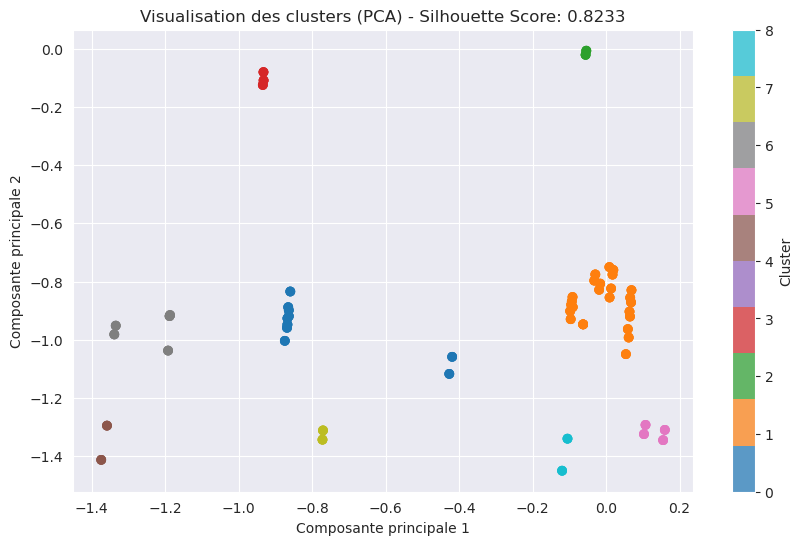


--- Exemples pour chaque cluster ---

--- Exemples pour le cluster 1 ---
+----------+----------+-------+-------------------+----------+--------+--------+
|marque    |modele    |prix   |unified_horse_power|rejets_co2|nbplaces|nbportes|
+----------+----------+-------+-------------------+----------+--------+--------+
|renault   |laguna    |19110.0|170.0              |0.0       |5.0     |5.0     |
|kia       |picanto   |8990.0 |65.0               |15.5      |5.0     |5.0     |
|peugeot   |1007      |9625.0 |75.0               |12.8      |5.0     |5.0     |
|renault   |megane    |22350.0|135.0              |0.0       |5.0     |5.0     |
|volkswagen|new beatle|26630.0|110.0              |13.3      |5.0     |5.0     |
+----------+----------+-------+-------------------+----------+--------+--------+
only showing top 5 rows


--- Exemples pour le cluster 6 ---
+--------+------+-------+-------------------+----------+--------+--------+
|marque  |modele|prix   |unified_horse_power|rejets_co2|nbpla

In [57]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import when, col, lit
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Initialisation de la session Spark
spark = SparkSession.builder \
    .appName("Clustering Véhicules") \
    .enableHiveSupport() \
    .getOrCreate()
print("Session Spark initialisée avec succès.")
spark.sql("USE concessionnaire")

# Charger les données
catalogue_df = spark.sql("SELECT * FROM catalogue_co2_merge_processed")
print(f"Nombre de lignes dans le DataFrame initial : {catalogue_df.count()}")
catalogue_df.show(5, truncate=False)

# Étape 1 : Préparation des données pour le clustering
numerical_cols = ['prix', 'unified_horse_power', 'rejets_co2', 'bonus_malus', 'nbplaces', 'nbportes']
clustering_df = catalogue_df.select(
    *[col(c).cast('double').alias(c) for c in numerical_cols],
    'marque', 'modele'
).fillna({c: 0 for c in numerical_cols})

assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features_raw')
assembled_df = assembler.transform(clustering_df)

scaler = MinMaxScaler(inputCol='features_raw', outputCol='features')
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

print("Données normalisées prêtes pour le clustering :")
scaled_df.select("features").show(5, truncate=False)

# Étape 2 : Clustering avec K-Means
k = 9
kmeans = KMeans(featuresCol='features', k=k, seed=1)
model = kmeans.fit(scaled_df)
clustered_df = model.transform(scaled_df)

# Calcul du score de silhouette
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')
silhouette_score = evaluator.evaluate(clustered_df)
print(f"Score de silhouette pour k={k}: {silhouette_score:.4f}")

# Étape 3 : Analyse des clusters
print("\n--- Répartition des clusters ---")
clustered_df.groupBy('prediction').count().orderBy('prediction').show()

print("\n--- Statistiques des clusters ---")
cluster_stats = clustered_df.groupBy('prediction').agg(
    F.count('*').alias('count'),
    *[F.mean(c).alias(f'mean_{c}') for c in numerical_cols],
    *[F.stddev(c).alias(f'stddev_{c}') for c in numerical_cols]
)
cluster_stats.show(truncate=False)

# Étape 4 : Réduction de dimensions pour visualisation
print("\n--- Réduction de dimensions avec PCA ---")
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(clustered_df)
pca_df = pca_model.transform(clustered_df)

# Collecte des données pour Matplotlib
pca_data = pca_df.select("pca_features", "prediction").rdd.map(
    lambda row: (row["pca_features"][0], row["pca_features"][1], row["prediction"])
).collect()

x_coords = [x[0] for x in pca_data]
y_coords = [x[1] for x in pca_data]
predictions = [x[2] for x in pca_data]

# Visualisation des clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_coords, y_coords, c=predictions, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.title(f"Visualisation des clusters (PCA) - Silhouette Score: {silhouette_score:.4f}")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

# Étape 5 : Vérification des catégories
print("\n--- Exemples pour chaque cluster ---")
categories = clustered_df.select("prediction").distinct().rdd.flatMap(lambda x: x).collect()
for cluster in categories:
    print(f"\n--- Exemples pour le cluster {cluster} ---")
    clustered_df.filter(col("prediction") == cluster).select(
        "marque", "modele", "prix", "unified_horse_power", "rejets_co2", "nbplaces", "nbportes"
    ).show(5, truncate=False)


In [58]:
clustered_df.groupBy("prediction").count().show()


+----------+-----+
|prediction|count|
+----------+-----+
|         1|  125|
|         6|   25|
|         5|   20|
|         4|   10|
|         8|   10|
|         2|   10|
|         0|   50|
|         3|   15|
|         7|   10|
+----------+-----+


In [60]:
# Ajouter des catégories pour chaque cluster
clustered_df = clustered_df.withColumn(
    "categorie",
    when(col("prediction") == 1, "Berlines compactes économiques")
    .when(col("prediction") == 6, "Compactes premium")
    .when(col("prediction") == 5, "Monospaces familiaux 7 places")
    .when(col("prediction") == 4, "Berlines de luxe haut de gamme")
    .when(col("prediction") == 8, "Voitures sportives haut de gamme")
    .when(col("prediction") == 2, "Citadines économiques compactes")
    .when(col("prediction") == 0, "Berlines routières intermédiaires")
    .when(col("prediction") == 3, "Micro-citadines économiques")
    .when(col("prediction") == 7, "Monospaces compacts économiques")
    .otherwise("Non défini")
)

# Afficher les données avec les catégories
print("\n--- Véhicules avec catégories assignées ---")
clustered_df.select(
    "marque", "modele", "prix", "unified_horse_power", "rejets_co2", "nbplaces", "nbportes", "categorie"
).show(100, truncate=False)

# Sauvegarder les résultats pour un usage ultérieur
# clustered_df.write.mode('overwrite').saveAsTable("concessionnaire.clustered_with_categories")



--- Véhicules avec catégories assignées ---
+----------+----------+--------+-------------------+----------+--------+--------+---------------------------------+
|marque    |modele    |prix    |unified_horse_power|rejets_co2|nbplaces|nbportes|categorie                        |
+----------+----------+--------+-------------------+----------+--------+--------+---------------------------------+
|renault   |laguna    |19110.0 |170.0              |0.0       |5.0     |5.0     |Berlines compactes économiques   |
|kia       |picanto   |8990.0  |65.0               |15.5      |5.0     |5.0     |Berlines compactes économiques   |
|peugeot   |1007      |9625.0  |75.0               |12.8      |5.0     |5.0     |Berlines compactes économiques   |
|volkswagen|polo      |12200.0 |55.0               |13.3      |5.0     |3.0     |Citadines économiques compactes  |
|mercedes  |a200      |18130.0 |136.0              |171.2     |5.0     |5.0     |Compactes premium                |
|renault   |megane    |2235